In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Cell 1: Imports and notebook settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.interpolate import UnivariateSpline

# For nicer tables if needed
pd.set_option('display.width', 80)
pd.set_option('display.max_columns', 20)

# Load CSV and inspect
df_raw = pd.read_csv('yield-curve-rates-1990-2023.csv.csv')

# Inspect the first few rows
df_raw.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/29/23,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03
1,12/28/23,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2,12/27/23,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
3,12/26/23,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
4,12/22/23,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05


In [26]:
# Cell 2: Parse dates and rename tenors uniformly

# 1) Make a copy (assumes df_raw already exists)
df = df_raw.copy()

# 2) Parse the Date column; adjust format if your CSV uses something else
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
    
column_map = {
    '1 Mo':   '0.0833',   # 1/12
    '3 Mo':   '0.25',
    '6 Mo':   '0.5',
    '1 Yr':   '1.0',
    '2 Yr':   '2.0',
    '3 Yr':   '3.0',
    '5 Yr':   '5.0',
    '7 Yr':   '7.0',
    '10 Yr':  '10.0',
    '20 Yr':  '20.0',
    '30 Yr':  '30.0'
}

df = df.rename(columns=column_map)

# Keep only Date + the tenors we intend to use
tenors = ['2.0', '3.0', '5.0', '7.0', '10.0', '20.0', '30.0']
missing = [t for t in tenors if t not in df.columns]
assert not missing, f"Missing tenor columns: {missing}"

df = df[['Date'] + tenors]
df = df.sort_values('Date').reset_index(drop=True)

# Convert yields to decimals (e.g. 2.54% → 0.0254)
for t in tenors:
    df[t] = df[t] / 100.0

df.head()

,Date,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0,1990-01-02,0.0787,0.0790,0.0787,0.0798,0.0794,NaN,0.0800
1,1990-01-03,0.0794,0.0796,0.0792,0.0804,0.0799,NaN,0.0804
2,1990-01-04,0.0792,0.0793,0.0791,0.0802,0.0798,NaN,0.0804
3,1990-01-05,0.0790,0.0794,0.0792,0.0803,0.0799,NaN,0.0806
4,1990-01-08,0.0790,0.0795,0.0792,0.0805,0.0802,NaN,0.0809


In [30]:
# Cell 3: Create shifted yields (approx. one‐month = 21 trading days)
lag_days = 21

df_shifted = df.copy()
for t in tenors:
    df_shifted[f"{t}_lagged"] = df_shifted[t].shift(-lag_days)

# Drop any rows where lagged data is NaN (i.e. at the end)
df_deltas = df_shifted.dropna().copy()

# Compute the one‐month change for each tenor
for t in tenors:
    df_deltas[f"d_{t}"] = df_deltas[f"{t}_lagged"] - df_deltas[t]

# Build a new DataFrame X with only the delta‐columns
delta_cols = [f"d_{t}" for t in tenors]
X = df_deltas[delta_cols].values
dates_X = df_deltas['Date'].values

# Quick sanity check: show first few rows of changes
pd.DataFrame(df_deltas[delta_cols + ['Date']].head())

,d_2.0,d_3.0,d_5.0,d_7.0,d_10.0,d_20.0,d_30.0,Date
369,0.0034,0.0032,0.0037,0.0038,0.0037,0.0019,0.0019,1993-10-01
370,0.0033,0.0033,0.0036,0.0034,0.0034,0.0019,0.0016,1993-10-04
371,0.0035,0.0035,0.0041,0.0040,0.0038,0.0022,0.0018,1993-10-05
372,0.0045,0.0050,0.0059,0.0061,0.0057,0.0042,0.0040,1993-10-06
373,0.0046,0.0048,0.0057,0.0057,0.0055,0.0040,0.0036,1993-10-07


In [36]:
# Cell 4: Standardize the delta matrix
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit PCA
n_components = len(tenors)  # we can fit full PCA, then inspect first 3
pca = PCA(n_components=n_components)
pca.fit(X_std)

explained = pca.explained_variance_ratio_ * 100  # as percentage
explained_cum = np.cumsum(explained)

# Build a DataFrame of explained variances
df_explained = pd.DataFrame({
    'PC': [f"PC{i+1}" for i in range(n_components)],
    'Explained Variance (%)': np.round(explained, 2),
    'Cumulative (%)': np.round(explained_cum, 2)
})
df_explained.head(10)

,PC,Explained Variance (%),Cumulative (%)
0,PC1,90.62,90.62
1,PC2,8.12,98.74
2,PC3,0.87,99.61
3,PC4,0.17,99.77
4,PC5,0.13,99.90
5,PC6,0.06,99.96
6,PC7,0.04,100.00


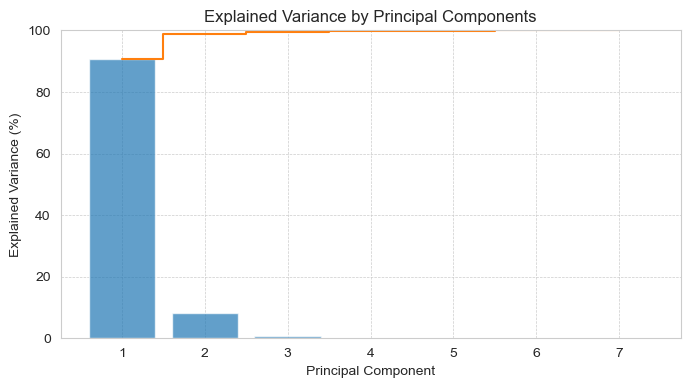

In [38]:
# Plot explained variance
plt.figure(figsize=(8,4))
plt.bar(range(1, n_components+1), explained, color='C0', alpha=0.7)
plt.step(range(1, n_components+1), explained_cum, where='mid', color='C1')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, n_components+1))
plt.ylim(0, 100)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


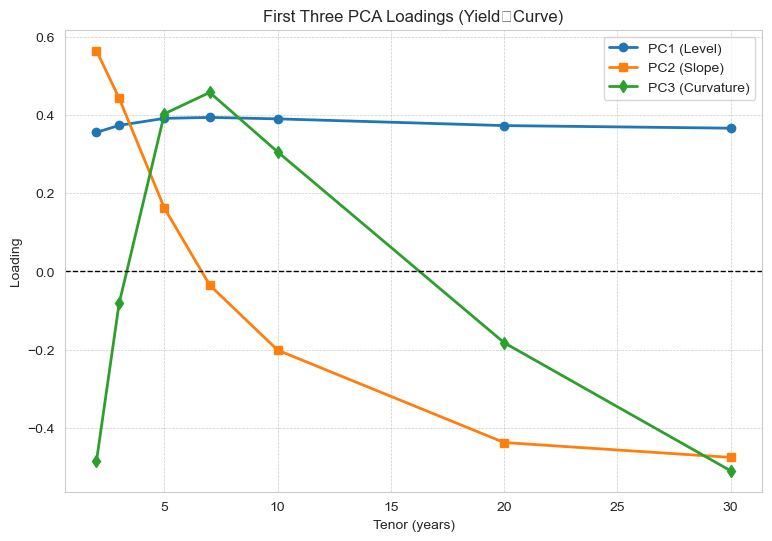

In [42]:
# Cell 5: Project the standardized data onto the first three principal components
Y = pca.transform(X_std)  # full projection
Y1, Y2, Y3 = Y[:,0], Y[:,1], Y[:,2]  # time series of PC1, PC2, PC3

loadings = pca.components_  # shape: (n_components, n_tenors)
tau_nums = np.array([float(t) for t in tenors])  # convert tenor strings to floats

plt.figure(figsize=(9,6))
plt.plot(tau_nums, loadings[0, :], 'o-', lw=2, label='PC1 (Level)', color='C0')
plt.plot(tau_nums, loadings[1, :], 's-', lw=2, label='PC2 (Slope)', color='C1')
plt.plot(tau_nums, loadings[2, :], 'd-', lw=2, label='PC3 (Curvature)', color='C2')
plt.axhline(0, color='black', lw=1, linestyle='--')
plt.xlabel('Tenor (years)')
plt.ylabel('Loading')
plt.title('First Three PCA Loadings (Yield‐Curve)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

/var/folders/dh/vh_kvsnj41q6877kxnwy1c040000gn/T/ipykernel_18266/191943358.py:11: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


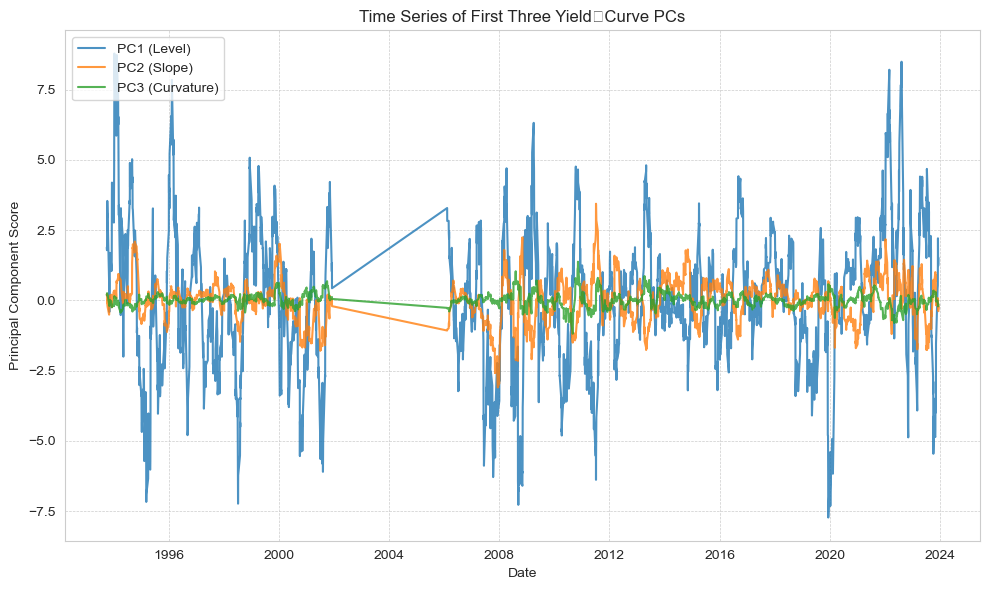

In [44]:
# Plot time series of PC1, PC2, PC3
plt.figure(figsize=(10, 6))
plt.plot(dates_X, Y1, label='PC1 (Level)', color='C0', alpha=0.8)
plt.plot(dates_X, Y2, label='PC2 (Slope)', color='C1', alpha=0.8)
plt.plot(dates_X, Y3, label='PC3 (Curvature)', color='C2', alpha=0.8)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Principal Component Score')
plt.title('Time Series of First Three Yield‐Curve PCs')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

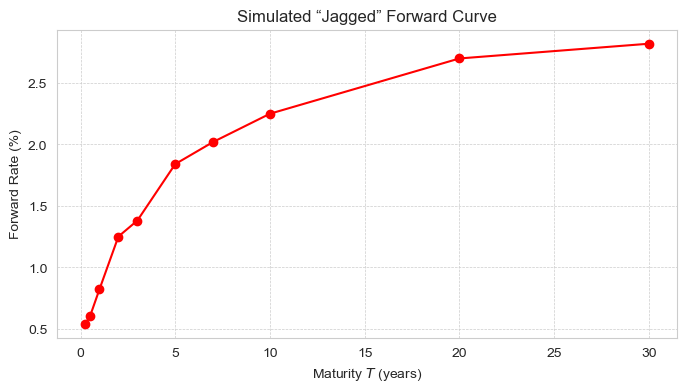

In [46]:
# Cell 6: Simulate a “jagged” forward curve at discrete maturities for illustration

# Suppose we have maturities (in years) where forward rates are observed irregularly:
T_obs = np.array([0.25, 0.50, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0])
# Simulated “jagged” forward rates (in decimal)
F_obs = np.array([0.0054, 0.0060, 0.0082, 0.0125, 0.0138, 0.0184, 0.0202, 0.0225, 0.0270, 0.0282])

plt.figure(figsize=(8,4))
plt.plot(T_obs, F_obs * 100, 'ro-', label='Observed Jagged Forwards')
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('Forward Rate (%)')
plt.title('Simulated “Jagged” Forward Curve')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

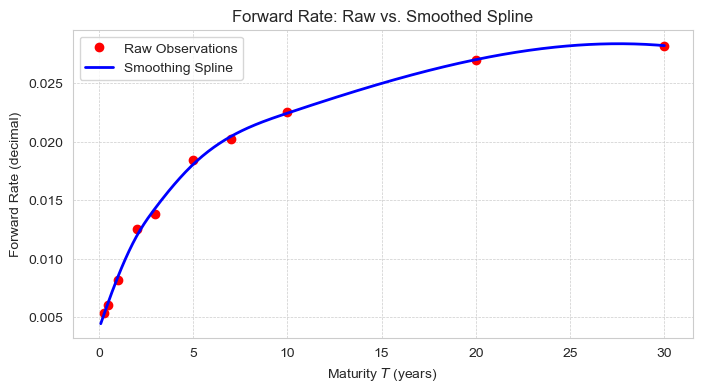

In [48]:
# Cell 7: Fit a smoothing spline to (T_obs, F_obs)

# Convert forward rates to basis points (optional) or keep decimals
# We'll keep decimals but choose a smoothing factor that interpolates fairly closely.

spline_smooth = UnivariateSpline(T_obs, F_obs, k=3, s=1e-6)  
# k=3 → cubic spline; s = smoothing factor (tune as needed)

# Create a fine grid to evaluate the spline
T_fine = np.linspace(0.1, 30.0, 300)
F_smooth = spline_smooth(T_fine)

plt.figure(figsize=(8,4))
plt.plot(T_obs, F_obs, 'ro', label='Raw Observations')
plt.plot(T_fine, F_smooth, 'b-', linewidth=2, label='Smoothing Spline')
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('Forward Rate (decimal)')
plt.title('Forward Rate: Raw vs. Smoothed Spline')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


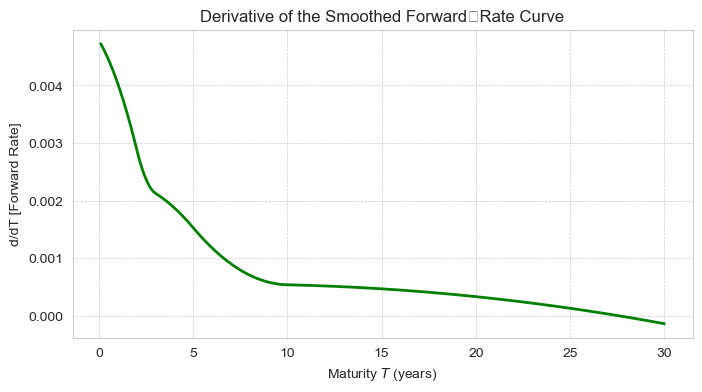

In [50]:
# Cell 13: Plot the derivative of the spline → which approximates the “instantaneous forward‐rate derivative”

F_spline_prime = spline_smooth.derivative()(T_fine)

plt.figure(figsize=(8,4))
plt.plot(T_fine, F_spline_prime, 'g-', linewidth=2)
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('d/dT [Forward Rate]')
plt.title('Derivative of the Smoothed Forward‐Rate Curve')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()